In [1]:
import os, random
import numpy as np
import cv2

In [2]:
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
ia.seed(2)

In [3]:
base_dir = '/home/ai_competition36'
img_dir = os.path.join(base_dir, 'backsub_images')
txt_dir = os.path.join(base_dir, 'backsub_txts')
#modified_dir = base_dir + '/1.competition_trainset/modified1' # 합성된 사진은 modified폴더에 저장
backgrounds_dir = os.path.join(base_dir, 'backgrounds') # 배경은 backgrounds 폴더에 저장

In [4]:
#두 이미지를 합성, img1이 아래에, img2가 위에 합성됨
#주의! 모든 이미지는 (460, 640, 3) 의 크기여야 함
#input은 cv2.imread로 읽어들인 이미지 파일
def addimage(img1, img2):
  rows, cols, channels = img2.shape

  img2gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  img1_bg = cv2.bitwise_and(img1, img1, mask=mask_inv)

  img2_fg = cv2.bitwise_and(img2, img2, mask=mask)

  return cv2.add(img1_bg, img2_fg)

In [5]:
class bbox:
    def __init__(self, id, x, y, w, h):
        self.id = id
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    def show(self):
        print(f'{self.id} {self.x} {self.y} {self.w} {self.h}\n')
    def move(self, des_x, des_y):
        self.x = des_x
        self.y = des_y
    def line(self):
        return "{} {} {} {} {}".format(self.id, self.x, self.y, self.w, self.h)

In [6]:
#설정한 x,y만큼 이미지를 이동, 이때 원점은 이미지의 좌측 상단 꼭짓점 기준임
'''
def move(img, x, y):
  h, w = img.shape[:2]
  M = np.float32([[1, 0 ,x],[0, 1, y]])
  return cv2.warpAffine(img, M, (w, h))
'''
# 설정된 x,y좌표로 바운딩 박스의 중심좌표를 이동 (이때 이미지의 크기는 (640, 480))
# 이때 x,y좌표는 normailized 된 값(0~1사이의 값)을 받는다.
def move(img, bbox, x, y):
    h, w = img.shape[:2]
    delta_x = (x - bbox.x) * 640
    delta_y = (y - bbox.y) * 480
    bbox.move(x, y)
    M = np.float32([[1, 0 ,delta_x],[0, 1, delta_y]])
    return cv2.warpAffine(img, M, (w, h))

In [7]:
#주어진 이미지를 (480, 640, 3)크기로 축소 
def resize(img):
    res = cv2.resize(img, dsize=(640, 480), interpolation=cv2.INTER_AREA)
    return res

# Img synthesis

In [15]:
# 넉넉잡아 합성할 물체 8가지를 뽑는다. (주어진 이미지 사이즈를 벗어나면 합성이 안되도록 함; 아니면 이미지 사이즈를 그에 맞게 키우면?)
rand_item_list = random.sample(os.listdir(img_dir),10)
print(rand_item_list)

['28.quaker_big_chewy_chocolate_chip', '35.clif_z_bar_chocolate_chip', '41.nabisco_nilla', '12.pringles_bbq', '16.mom_to_mom_sweet_potato_corn_apple', '56.monster_energy', '5.hersheys_cocoa', '57.act_ii_butter_lovers_popcorn', '4.crayola_24_crayons', '0.aunt_jemima_original_syrup']


In [39]:
# 8개의 물건 리스트의 물체들을 합성시키는데, 이때
# (1) 왼쪽에서 오른쪽, (2) 오른쪽에서 왼쪽 (3) 위에서 아래 (4) 아래에서 위 (5)(6) 대각선 방향으로 합성시킨다.
# 각각의 경우에서 물체들이 끝에 도달하여 더이상 물체를 합성시킬 수 없을 때 그만 합성한다.
item_path_list = []
for item in rand_item_list:                             # 8개의 물체에 대해 랜덤한 이미지 파일의 이름까지 포함한 item_path_list를 만든다.
    temp_item_path = os.path.join(img_dir, item)
    img_file_name = random.choice(os.listdir(temp_item_path))
    item_path_list.append(os.path.join(item, img_file_name))
#print(item_path_list)

# 각각의 이미지에 대해 txt파일을 읽어들여 bounding box의 정보를 저장한다.
bbox_list = []                                           # bbox정보를 담은 리스트 생성
for item_path in item_path_list:
    txt_path = os.path.join(txt_dir, item_path[0:-3] + 'txt')
    f = open(txt_path, 'r')
    line = f.readline()
    line.strip() # 줄 끝의 줄 바꿈 문자 제거
    b = line.split()
    bbox_list.append(bbox(id=b[0],x=float(b[1]),y=float(b[2]),w=float(b[3]),h=float(b[4])))
    f.close()
    
for x in bbox_list:
    print(x.line())
    print('\n')




28 0.36796875 0.6229166666666667 0.2421875 0.38333333333333336


35 0.459375 0.6385416666666667 0.365625 0.41041666666666665


41 0.534375 0.49895833333333334 0.2125 0.47291666666666665


12 0.47109375 0.4239583333333333 0.1859375 0.46041666666666664


16 0.4484375 0.5947916666666667 0.228125 0.35208333333333336


56 0.3734375 0.5052083333333334 0.134375 0.35208333333333336


5 0.44140625 0.5177083333333333 0.1078125 0.23125


57 0.60078125 0.6291666666666667 0.2296875 0.42083333333333334


4 0.49609375 0.39479166666666665 0.2640625 0.26458333333333334


0 0.45859375 0.47708333333333336 0.1546875 0.4041666666666667




In [40]:
N = len(item_path_list)
#N=100 #임시로 작게 설정
height = 480
width = 640
channels = 3
images = np.zeros((N, height, width, channels), dtype=np.uint8)
for idx, item_path in enumerate(item_path_list):
    images[idx, :, :, :] = imageio.imread(os.path.join(img_dir, item_path))

# 총 8가지 방법으로 겹치기

## 가로(왼쪽, 오른쪽), 세로(위, 아래), 대각선(남동, 남서, 북동, 북서)

# 1. 가로로 겹치기(왼쪽 -> 오른쪽)

In [41]:
# 첫 번째 이미지는 왼쪽(또는 오른쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
first_img_start_point = 0.01
target_x = first_img_start_point + bbox_list[0].w / 2
target_y = 0.5                           # target_y는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다

# 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
images[0] = move(images[0], bbox_list[0], target_x, target_y)

# 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
base_img = images[0]

# 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(x축 기준)를 기준으로 겹치게 위치시킨다.

overlap = 0.5 # 몇 퍼센트 겹치게 할건지
next_img_start_point = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap) # overlap 비율만큼 겹치도록 다음 이미지가 시작되는 지점을 계산.

for i in range(1,N):
    target_x = next_img_start_point + bbox_list[i].w / 2
    # target_y = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
    if target_x + bbox_list[i].w / 2 > 1: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
        continue
    
    images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
    base_img = addimage(base_img, images[i])
    
    next_img_start_point = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap)

# 2.가로로 겹치기(오른쪽 -> 왼쪽)

In [21]:
# 첫 번째 이미지는 왼쪽(또는 오른쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
first_img_start_point = 0.01
target_x = 1 - (first_img_start_point + bbox_list[0].w / 2) # 오른쪽에서 시작할 거기 때문에 1에서 빼준다
target_y = 0.5                           # target_y는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다

# 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
images[0] = move(images[0], bbox_list[0], target_x, target_y)

# 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
base_img = images[0]

# 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(x축 기준)를 기준으로 겹치게 위치시킨다.

overlap = 0.3 # 몇 퍼센트 겹치게 할건지
next_img_start_point = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
# next_img_start_point 오른쪽에서 왼쪽으로 가도록 수정
for i in range(1,N):
    target_x = next_img_start_point - bbox_list[i].w / 2
    # target_y = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
    if target_x - bbox_list[i].w / 2 < 0: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
        continue
    
    images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
    base_img = addimage(base_img, images[i])
    
    next_img_start_point = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap)

# 3. 세로로 겹치기 (위 -> 아래)

In [20]:
# 첫 번째 이미지는 위쪽(또는 아래쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
first_img_start_point = 0.01
target_x = 0.5                           # target_x는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
target_y = first_img_start_point + bbox_list[0].h / 2 # 위에서 부터 시작

# 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
images[0] = move(images[0], bbox_list[0], target_x, target_y)

# 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
base_img = images[0]

# 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(y축 기준)를 기준으로 겹치게 위치시킨다.

overlap = 0.5 # 몇 퍼센트 겹치게 할건지
next_img_start_point = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
# next_img_start_point 오른쪽에서 왼쪽으로 가도록 수정
for i in range(1,N):
    # target_x = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
    target_y = next_img_start_point + bbox_list[i].h / 2
    if target_y + bbox_list[i].h / 2 > 1: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
        continue
    
    images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
    base_img = addimage(base_img, images[i])
    
    next_img_start_point = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap)

# 4. 세로로 겹치기 (아래 -> 위)

In [23]:
# 첫 번째 이미지는 위쪽(또는 아래쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
first_img_start_point = 0.01
target_x = 0.5                           # target_x는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
target_y = 1 - (first_img_start_point + bbox_list[0].h / 2) # 아래에서 부터 시작

# 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
images[0] = move(images[0], bbox_list[0], target_x, target_y)

# 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
base_img = images[0]

# 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(y축 기준)를 기준으로 겹치게 위치시킨다.

overlap = 0.5 # 몇 퍼센트 겹치게 할건지
next_img_start_point = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
# next_img_start_point 오른쪽에서 왼쪽으로 가도록 수정
for i in range(1,N):
    # target_x = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
    target_y = next_img_start_point - bbox_list[i].h / 2
    if target_y - bbox_list[i].h / 2 < 0: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
        continue
    
    images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
    base_img = addimage(base_img, images[i])
    
    next_img_start_point = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap)

# 5.6.7.8. 대각선 겹치기 (어캐하지)

In [27]:
# 남동쪽 방향

# 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
first_img_start_point_x = 0.01 # 왼쪽 위 구석에서 시작
first_img_start_point_y = 0.01
target_x = first_img_start_point_x + bbox_list[0].w / 2 
target_y = first_img_start_point_y + bbox_list[0].h / 2  

# 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
images[0] = move(images[0], bbox_list[0], target_x, target_y)

# 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
base_img = images[0]

# 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

overlap_x = 0.5 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
overlap_y = 0.5 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
next_img_start_point_x = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap_x)
next_img_start_point_y = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
# next_img_start_point 오른쪽에서 왼쪽으로 가도록 수정
for i in range(1,N):
    target_x = next_img_start_point_x + bbox_list[i].w / 2
    target_y = next_img_start_point_y + bbox_list[i].h / 2
    if target_x + bbox_list[i].w / 2 > 1 or target_y + bbox_list[i].h / 2 > 1 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
        continue
    
    images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
    base_img = addimage(base_img, images[i])
    
    next_img_start_point_x = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap_y)

In [29]:
# 남서쪽 방향

# 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
first_img_start_point_x = 1 - 0.01 # 오른쪽 위 구석에서 시작
first_img_start_point_y = 0.01
target_x = first_img_start_point_x - bbox_list[0].w / 2 
target_y = first_img_start_point_y + bbox_list[0].h / 2  

# 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
images[0] = move(images[0], bbox_list[0], target_x, target_y)

# 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
base_img = images[0]

# 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

overlap_x = 0.5 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
overlap_y = 0.5 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
next_img_start_point_x = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap_x)
next_img_start_point_y = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
# next_img_start_point 오른쪽에서 왼쪽으로 가도록 수정
for i in range(1,N):
    target_x = next_img_start_point_x - bbox_list[i].w / 2
    target_y = next_img_start_point_y + bbox_list[i].h / 2
    if target_x - bbox_list[i].w / 2 < 0 or target_y + bbox_list[i].h / 2 > 1 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
        continue
    
    images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
    base_img = addimage(base_img, images[i])
    
    next_img_start_point_x = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap_y)

In [31]:
# 북동쪽 방향

# 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
first_img_start_point_x = 0.01
first_img_start_point_y = 1 - 0.01
target_x = first_img_start_point_x + bbox_list[0].w / 2 
target_y = first_img_start_point_y - bbox_list[0].h / 2  

# 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
images[0] = move(images[0], bbox_list[0], target_x, target_y)

# 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
base_img = images[0]

# 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

overlap_x = 0.6 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
overlap_y = 0.6 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
next_img_start_point_x = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap_x)
next_img_start_point_y = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
# next_img_start_point 오른쪽에서 왼쪽으로 가도록 수정
for i in range(1,N):
    target_x = next_img_start_point_x + bbox_list[i].w / 2
    target_y = next_img_start_point_y - bbox_list[i].h / 2
    if target_x + bbox_list[i].w / 2 > 1 or target_y - bbox_list[i].h / 2 < 0 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
        continue
    
    images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
    base_img = addimage(base_img, images[i])
    
    next_img_start_point_x = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap_y)

In [35]:
# 북서쪽 방향

# 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
first_img_start_point_x = 1 - 0.01
first_img_start_point_y = 1-  0.01
target_x = first_img_start_point_x - bbox_list[0].w / 2 # 왼쪽 위 모서리에서부터 시작
target_y = first_img_start_point_y - bbox_list[0].h / 2  

# 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
images[0] = move(images[0], bbox_list[0], target_x, target_y)

# 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
base_img = images[0]

# 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

overlap_x = 0.5 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
overlap_y = 0.5 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
next_img_start_point_x = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap_x)
next_img_start_point_y = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
# next_img_start_point 오른쪽에서 왼쪽으로 가도록 수정
for i in range(1,N):
    target_x = next_img_start_point_x - bbox_list[i].w / 2
    target_y = next_img_start_point_y - bbox_list[i].h / 2
    if target_x - bbox_list[i].w / 2 < 0 or target_y - bbox_list[i].h / 2 < 0 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
        continue
    
    images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
    base_img = addimage(base_img, images[i])
    
    next_img_start_point_x = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap_y)

# 바운딩 박스를 사진 위에 그려서 확인해보기

In [11]:
# 그려진 바운딩 박스 테스트
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline

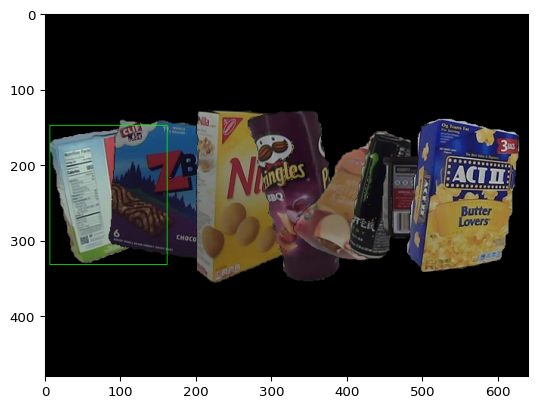

In [42]:
idx = 0
x = bbox_list[idx].x
y = bbox_list[idx].y
w = bbox_list[idx].w
h = bbox_list[idx].h
a1 = 640 * (x - w/2)
a2 = 640 * (x + w/2)
b1 = 480 * (y - h/2)
b2 = 480 * (y + h/2)

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=a1, x2=a2, y1=b1, y2=b2)
], shape=base_img.shape)

ia.imshow(bbs.draw_on_image(base_img))

# 이제 진짜 파일을 만들어보자

## 랜덤으로 8개의 아이템을 뽑고, 그 8개의 아이템을 8가지 방법으로 겹쳐본다

## 8가지 방법은 (1)(2) 가로 (3)(4) 세로 (5)(6)(7)(8) 대각선

In [1]:
import os, random
import numpy as np
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
ia.seed(5)

In [2]:
base_dir = '/home/ai_competition36'
img_dir = os.path.join(base_dir, 'backsub_images')
txt_dir = os.path.join(base_dir, 'backsub_txts')
#overlap_dir = base_dir + '/4.trainset_overlap/overlap1' # 합성된 사진은 overlap1폴더에 저장
backgrounds_dir = os.path.join(base_dir, 'backgrounds') # 배경은 backgrounds 폴더에 저장

In [3]:
#두 이미지를 합성, img1이 아래에, img2가 위에 합성됨
#주의! 모든 이미지는 (460, 640, 3) 의 크기여야 함
#input은 cv2.imread로 읽어들인 이미지 파일
def addimage(img1, img2):
  rows, cols, channels = img2.shape

  img2gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  img1_bg = cv2.bitwise_and(img1, img1, mask=mask_inv)

  img2_fg = cv2.bitwise_and(img2, img2, mask=mask)

  return cv2.add(img1_bg, img2_fg)

In [4]:
class bbox:
    def __init__(self, id, x, y, w, h):
        self.id = id
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    def show(self):
        print(f'{self.id} {self.x} {self.y} {self.w} {self.h}\n')
    def move(self, des_x, des_y):
        self.x = des_x
        self.y = des_y
    def line(self):
        return "{} {} {} {} {}".format(self.id, self.x, self.y, self.w, self.h)

In [5]:
# 설정된 x,y좌표로 바운딩 박스의 중심좌표를 이동 (이때 이미지의 크기는 (640, 480))
# 이때 x,y좌표는 normailized 된 값(0~1사이의 값)을 받는다.
def move(img, bbox, x, y):
    h, w = img.shape[:2]
    delta_x = (x - bbox.x) * 640
    delta_y = (y - bbox.y) * 480
    bbox.move(x, y)
    M = np.float32([[1, 0 ,delta_x],[0, 1, delta_y]])
    return cv2.warpAffine(img, M, (w, h))

In [6]:
iternum = 500 # iternum * 8개의 이미지가 만들어진다.

In [7]:
count = 0
for it in range(iternum):
    if it % 1000 == 0:
        count = count + 1
        print(f'{it}iterating')
    overlap_dir = base_dir + f'/2-1.testsetplus' # 합성된 사진은 overlap1폴더에 저장
    # 넉넉잡아 합성할 물체 8가지를 뽑는다. (주어진 이미지 사이즈를 벗어나면 합성이 안되도록 함; 아니면 이미지 사이즈를 그에 맞게 키우면?)
    rand_item_list = random.sample(os.listdir(img_dir),10)
    #print(rand_item_list)
    
    # 8개의 물건 리스트의 물체들을 합성시키는데, 이때
    # (1) 왼쪽에서 오른쪽, (2) 오른쪽에서 왼쪽 (3) 위에서 아래 (4) 아래에서 위 (5)(6) 대각선 방향으로 합성시킨다.
    # 각각의 경우에서 물체들이 끝에 도달하여 더이상 물체를 합성시킬 수 없을 때 그만 합성한다.
    item_path_list = []
    for item in rand_item_list:                             # 8개의 물체에 대해 랜덤한 이미지 파일의 이름까지 포함한 item_path_list를 만든다.
        temp_item_path = os.path.join(img_dir, item)
        img_file_name = random.choice(os.listdir(temp_item_path))
        item_path_list.append(os.path.join(item, img_file_name))
    #print(item_path_list)

    # 각각의 이미지에 대해 txt파일을 읽어들여 bounding box의 정보를 저장한다.
    bbox_list = []                                           # bbox정보를 담은 리스트 생성
    for item_path in item_path_list:
        txt_path = os.path.join(txt_dir, item_path[0:-3] + 'txt')
        f = open(txt_path, 'r')
        line = f.readline()
        line.strip() # 줄 끝의 줄 바꿈 문자 제거
        b = line.split()
        bbox_list.append(bbox(id=b[0],x=float(b[1]),y=float(b[2]),w=float(b[3]),h=float(b[4])))
        f.close()

    # 이미지 파일을 images라는 numpy array에 저장한다.
    N = len(item_path_list)
    height = 480
    width = 640
    channels = 3
    images = np.zeros((N, height, width, channels), dtype=np.uint8)
    for idx, item_path in enumerate(item_path_list):
        images[idx, :, :, :] = imageio.imread(os.path.join(img_dir, item_path))
    
    #for x in bbox_list:
    #    x.show()

    # 귀찮으니 ctrl c, ctrl v
    # 8가지 방법들 적용
    
    # 1. 가로
    # 첫 번째 이미지는 왼쪽(또는 오른쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
    first_img_start_point = 0.01
    target_x = first_img_start_point + bbox_list[0].w / 2
    target_y = 0.5                           # target_y는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
    file_name = f'/{it}_horizontal1'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(x축 기준)를 기준으로 겹치게 위치시킨다.

    overlap = 0.5 # 몇 퍼센트 겹치게 할건지
    next_img_start_point = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point + bbox_list[i].w / 2
        # target_y = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
        if target_x + bbox_list[i].w / 2 > 1: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())
        
        next_img_start_point = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap)
    
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 2. 가로2
    # 첫 번째 이미지는 왼쪽(또는 오른쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
    first_img_start_point = 0.01
    target_x = 1 - (first_img_start_point + bbox_list[0].w / 2) # 오른쪽에서 시작할 거기 때문에 1에서 빼준다
    target_y = 0.5                           # target_y는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
    file_name = f'/{it}_horizontal2'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(x축 기준)를 기준으로 겹치게 위치시킨다.

    overlap = 0.5 # 몇 퍼센트 겹치게 할건지
    next_img_start_point = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point - bbox_list[i].w / 2
        # target_y = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
        if target_x - bbox_list[i].w / 2 < 0: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 3. 세로1
    
    # 첫 번째 이미지는 위쪽(또는 아래쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
    first_img_start_point = 0.01
    target_x = 0.5                           # target_x는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
    target_y = first_img_start_point + bbox_list[0].h / 2 # 위에서 부터 시작
    file_name = f'/{it}_vertical1'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(y축 기준)를 기준으로 겹치게 위치시킨다.

    overlap = 0.5 # 몇 퍼센트 겹치게 할건지
    next_img_start_point = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        # target_x = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
        target_y = next_img_start_point + bbox_list[i].h / 2
        if target_y + bbox_list[i].h / 2 > 1: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 4. 세로2
    
    # 첫 번째 이미지는 위쪽(또는 아래쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
    first_img_start_point = 0.01
    target_x = 0.5                           # target_x는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
    target_y = 1 - (first_img_start_point + bbox_list[0].h / 2) # 아래에서 부터 시작
    file_name = f'/{it}_vertical2'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(y축 기준)를 기준으로 겹치게 위치시킨다.

    overlap = 0.5 # 몇 퍼센트 겹치게 할건지
    next_img_start_point = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        # target_x = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
        target_y = next_img_start_point - bbox_list[i].h / 2
        if target_y - bbox_list[i].h / 2 < 0: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 5. 대각선1
    
    # 남동쪽 방향

    # 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
    first_img_start_point_x = 0.01 # 왼쪽 위 구석에서 시작
    first_img_start_point_y = 0.01
    target_x = first_img_start_point_x + bbox_list[0].w / 2 
    target_y = first_img_start_point_y + bbox_list[0].h / 2
    file_name = f'/{it}_diagonal1'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

    overlap_x = 0.5 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
    overlap_y = 0.5 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
    next_img_start_point_x = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point_x + bbox_list[i].w / 2
        target_y = next_img_start_point_y + bbox_list[i].h / 2
        if target_x + bbox_list[i].w / 2 > 1 or target_y + bbox_list[i].h / 2 > 1 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point_x = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap_x)
        next_img_start_point_y = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap_y)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 6. 대각선2
    
    # 남서쪽 방향

    # 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
    first_img_start_point_x = 1 - 0.01 # 오른쪽 위 구석에서 시작
    first_img_start_point_y = 0.01
    target_x = first_img_start_point_x - bbox_list[0].w / 2 
    target_y = first_img_start_point_y + bbox_list[0].h / 2
    file_name = f'/{it}_diagonal2'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

    overlap_x = 0.5 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
    overlap_y = 0.5 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
    next_img_start_point_x = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point_x - bbox_list[i].w / 2
        target_y = next_img_start_point_y + bbox_list[i].h / 2
        if target_x - bbox_list[i].w / 2 < 0 or target_y + bbox_list[i].h / 2 > 1 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point_x = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap_x)
        next_img_start_point_y = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap_y)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 7. 대각선3
    
    # 북동쪽 방향

    # 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
    first_img_start_point_x = 0.01
    first_img_start_point_y = 1 - 0.01
    target_x = first_img_start_point_x + bbox_list[0].w / 2 
    target_y = first_img_start_point_y - bbox_list[0].h / 2
    file_name = f'/{it}_diagonal3'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

    overlap_x = 0.5 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
    overlap_y = 0.5 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
    next_img_start_point_x = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point_x + bbox_list[i].w / 2
        target_y = next_img_start_point_y - bbox_list[i].h / 2
        if target_x + bbox_list[i].w / 2 > 1 or target_y - bbox_list[i].h / 2 < 0 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point_x = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap_x)
        next_img_start_point_y = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap_y)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 8. 대각선4
    
    # 북서쪽 방향

    # 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
    first_img_start_point_x = 1 - 0.01
    first_img_start_point_y = 1-  0.01
    target_x = first_img_start_point_x - bbox_list[0].w / 2 # 왼쪽 위 모서리에서부터 시작
    target_y = first_img_start_point_y - bbox_list[0].h / 2
    file_name = f'/{it}_diagonal4'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

    overlap_x = 0.5 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
    overlap_y = 0.5 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
    next_img_start_point_x = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point_x - bbox_list[i].w / 2
        target_y = next_img_start_point_y - bbox_list[i].h / 2
        if target_x - bbox_list[i].w / 2 < 0 or target_y - bbox_list[i].h / 2 < 0 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point_x = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap_x)
        next_img_start_point_y = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap_y)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
print('All complete')

0iterating
All complete


모든 이미지들을 포함하도록 iteration 설정해보자

overlap 0.2 0.1

In [8]:
count = 0
for it in range(iternum):
    if it % 100 == 0:
        count = count + 1
        print(f'{it}iterating')
    overlap_dir = base_dir + f'/7.trainset_overlap_ppp/overlap' # 합성된 사진은 overlap1폴더에 저장
    # 넉넉잡아 합성할 물체 8가지를 뽑는다. (주어진 이미지 사이즈를 벗어나면 합성이 안되도록 함; 아니면 이미지 사이즈를 그에 맞게 키우면?)
    rand_item_list = random.sample(os.listdir(img_dir),10)
    #print(rand_item_list)
    
    # 8개의 물건 리스트의 물체들을 합성시키는데, 이때
    # (1) 왼쪽에서 오른쪽, (2) 오른쪽에서 왼쪽 (3) 위에서 아래 (4) 아래에서 위 (5)(6) 대각선 방향으로 합성시킨다.
    # 각각의 경우에서 물체들이 끝에 도달하여 더이상 물체를 합성시킬 수 없을 때 그만 합성한다.
    item_path_list = []
    for item in rand_item_list:                             # 8개의 물체에 대해 랜덤한 이미지 파일의 이름까지 포함한 item_path_list를 만든다.
        temp_item_path = os.path.join(img_dir, item)
        img_file_name = random.choice(os.listdir(temp_item_path))
        item_path_list.append(os.path.join(item, img_file_name))
    #print(item_path_list)

    # 각각의 이미지에 대해 txt파일을 읽어들여 bounding box의 정보를 저장한다.
    bbox_list = []                                           # bbox정보를 담은 리스트 생성
    for item_path in item_path_list:
        txt_path = os.path.join(txt_dir, item_path[0:-3] + 'txt')
        f = open(txt_path, 'r')
        line = f.readline()
        line.strip() # 줄 끝의 줄 바꿈 문자 제거
        b = line.split()
        bbox_list.append(bbox(id=b[0],x=float(b[1]),y=float(b[2]),w=float(b[3]),h=float(b[4])))
        f.close()

    # 이미지 파일을 images라는 numpy array에 저장한다.
    N = len(item_path_list)
    height = 480
    width = 640
    channels = 3
    images = np.zeros((N, height, width, channels), dtype=np.uint8)
    for idx, item_path in enumerate(item_path_list):
        images[idx, :, :, :] = imageio.imread(os.path.join(img_dir, item_path))
    
    #for x in bbox_list:
    #    x.show()

    # 귀찮으니 ctrl c, ctrl v
    # 8가지 방법들 적용
    
    # 1. 가로
    # 첫 번째 이미지는 왼쪽(또는 오른쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
    first_img_start_point = 0.01
    target_x = first_img_start_point + bbox_list[0].w / 2
    target_y = 0.5                           # target_y는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
    file_name = f'/{it}_horizontal1'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(x축 기준)를 기준으로 겹치게 위치시킨다.

    overlap = 0.1 # 몇 퍼센트 겹치게 할건지
    next_img_start_point = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point + bbox_list[i].w / 2
        # target_y = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
        if target_x + bbox_list[i].w / 2 > 1: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())
        
        next_img_start_point = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap)
    
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 2. 가로2
    # 첫 번째 이미지는 왼쪽(또는 오른쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
    first_img_start_point = 0.01
    target_x = 1 - (first_img_start_point + bbox_list[0].w / 2) # 오른쪽에서 시작할 거기 때문에 1에서 빼준다
    target_y = 0.5                           # target_y는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
    file_name = f'/{it}_horizontal2'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(x축 기준)를 기준으로 겹치게 위치시킨다.

    overlap = 0.1 # 몇 퍼센트 겹치게 할건지
    next_img_start_point = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point - bbox_list[i].w / 2
        # target_y = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
        if target_x - bbox_list[i].w / 2 < 0: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 3. 세로1
    
    # 첫 번째 이미지는 위쪽(또는 아래쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
    first_img_start_point = 0.01
    target_x = 0.5                           # target_x는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
    target_y = first_img_start_point + bbox_list[0].h / 2 # 위에서 부터 시작
    file_name = f'/{it}_vertical1'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(y축 기준)를 기준으로 겹치게 위치시킨다.

    overlap = 0.1 # 몇 퍼센트 겹치게 할건지
    next_img_start_point = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        # target_x = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
        target_y = next_img_start_point + bbox_list[i].h / 2
        if target_y + bbox_list[i].h / 2 > 1: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 4. 세로2
    
    # 첫 번째 이미지는 위쪽(또는 아래쪽)에 붙이고 y좌표는 0.5로 해서 정확히 중간에 오게함
    first_img_start_point = 0.01
    target_x = 0.5                           # target_x는 일단 0.5로 통일. 이후에 랜덤으로 조금씩 바꾸는 것도 가능하다
    target_y = 1 - (first_img_start_point + bbox_list[0].h / 2) # 아래에서 부터 시작
    file_name = f'/{it}_vertical2'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(y축 기준)를 기준으로 겹치게 위치시킨다.

    overlap = 0.1 # 몇 퍼센트 겹치게 할건지
    next_img_start_point = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        # target_x = 0,5로 통일이므로 따로 업데이트는 하지 않는다.
        target_y = next_img_start_point - bbox_list[i].h / 2
        if target_y - bbox_list[i].h / 2 < 0: # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 5. 대각선1
    
    # 남동쪽 방향

    # 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
    first_img_start_point_x = 0.01 # 왼쪽 위 구석에서 시작
    first_img_start_point_y = 0.01
    target_x = first_img_start_point_x + bbox_list[0].w / 2 
    target_y = first_img_start_point_y + bbox_list[0].h / 2
    file_name = f'/{it}_diagonal1'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

    overlap_x = 0.1 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
    overlap_y = 0.1 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
    next_img_start_point_x = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point_x + bbox_list[i].w / 2
        target_y = next_img_start_point_y + bbox_list[i].h / 2
        if target_x + bbox_list[i].w / 2 > 1 or target_y + bbox_list[i].h / 2 > 1 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point_x = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap_x)
        next_img_start_point_y = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap_y)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 6. 대각선2
    
    # 남서쪽 방향

    # 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
    first_img_start_point_x = 1 - 0.01 # 오른쪽 위 구석에서 시작
    first_img_start_point_y = 0.01
    target_x = first_img_start_point_x - bbox_list[0].w / 2 
    target_y = first_img_start_point_y + bbox_list[0].h / 2
    file_name = f'/{it}_diagonal2'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

    overlap_x = 0.1 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
    overlap_y = 0.1 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
    next_img_start_point_x = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[0].y + bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point_x - bbox_list[i].w / 2
        target_y = next_img_start_point_y + bbox_list[i].h / 2
        if target_x - bbox_list[i].w / 2 < 0 or target_y + bbox_list[i].h / 2 > 1 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point_x = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap_x)
        next_img_start_point_y = bbox_list[i].y + bbox_list[i].h * (0.5 - overlap_y)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 7. 대각선3
    
    # 북동쪽 방향

    # 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
    first_img_start_point_x = 0.01
    first_img_start_point_y = 1 - 0.01
    target_x = first_img_start_point_x + bbox_list[0].w / 2 
    target_y = first_img_start_point_y - bbox_list[0].h / 2
    file_name = f'/{it}_diagonal3'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

    overlap_x = 0.1 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
    overlap_y = 0.1 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
    next_img_start_point_x = bbox_list[0].x + bbox_list[0].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point_x + bbox_list[i].w / 2
        target_y = next_img_start_point_y - bbox_list[i].h / 2
        if target_x + bbox_list[i].w / 2 > 1 or target_y - bbox_list[i].h / 2 < 0 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point_x = bbox_list[i].x + bbox_list[i].w * (0.5 - overlap_x)
        next_img_start_point_y = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap_y)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
    #############################################################################################################
    
    # 8. 대각선4
    
    # 북서쪽 방향

    # 일단 45도 방향으로 움직이는 경우를 한 번 생각해보자
    first_img_start_point_x = 1 - 0.01
    first_img_start_point_y = 1-  0.01
    target_x = first_img_start_point_x - bbox_list[0].w / 2 # 왼쪽 위 모서리에서부터 시작
    target_y = first_img_start_point_y - bbox_list[0].h / 2
    file_name = f'/{it}_diagonal4'

    # 첫 번째 이미지의 위치를 옮김과 동시에 이미지의 바운딩 박스 정보도 업데이트한다.
    images[0] = move(images[0], bbox_list[0], target_x, target_y)

    # 첫 번째 이미지가 base가 되어 나머지 이미지들을 겹친다
    base_img = images[0]

    # 두 번째 ~ 마지막 번째 이미지 까지는 그 이전에 있는 물체와 겹치는 정도(넓이 기준)를 기준으로 겹치게 위치시킨다.

    overlap_x = 0.1 # 몇 퍼센트 겹치게 할건지(x축 길이 기준)
    overlap_y = 0.1 # 몇 퍼센트 겹치게 할건지(y축 길이 기준)
    next_img_start_point_x = bbox_list[0].x - bbox_list[0].w * (0.5 - overlap_x)
    next_img_start_point_y = bbox_list[0].y - bbox_list[0].h * (0.5 - overlap_y) # overlap 비율만큼 바운딩 박스가 겹치도록 다음 이미지가 시작되는 지점을 정해준다.
    
    fw = open(overlap_dir + file_name + '.txt', 'w') # txt파일에 저장하기 시작
    fw.write(bbox_list[0].line())
    
    for i in range(1,N):
        target_x = next_img_start_point_x - bbox_list[i].w / 2
        target_y = next_img_start_point_y - bbox_list[i].h / 2
        if target_x - bbox_list[i].w / 2 < 0 or target_y - bbox_list[i].h / 2 < 0 : # 만약 바운딩 박스가 이미지 바깥으로 나가게 된다면 다음 이미지를 시도해본다.
            continue

        images[i] = move(images[i], bbox_list[i], target_x, target_y) # 이미지를 target_x, target_y 좌표로 옮김, 동시에 bbox 좌표도 업데이트
        base_img = addimage(base_img, images[i])
        fw.write('\n' + bbox_list[i].line())

        next_img_start_point_x = bbox_list[i].x - bbox_list[i].w * (0.5 - overlap_x)
        next_img_start_point_y = bbox_list[i].y - bbox_list[i].h * (0.5 - overlap_y)
        
    fw.close()
    
    # 배경 합성
    background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
    background_img = imageio.imread(background_img_path)
    base_img = addimage(background_img, base_img)
    
    imageio.imwrite(overlap_dir + file_name + '.jpg', base_img) # base_img를 파일로 저장
    
print('All complete')

0iterating
100iterating
200iterating
300iterating
400iterating
500iterating
600iterating
700iterating
800iterating
900iterating
1000iterating
1100iterating
1200iterating
1300iterating
1400iterating
1500iterating
1600iterating
1700iterating
1800iterating
1900iterating
2000iterating
2100iterating
2200iterating
2300iterating
2400iterating
2500iterating
2600iterating
2700iterating
2800iterating
2900iterating
3000iterating
3100iterating
3200iterating
3300iterating
3400iterating
3500iterating
3600iterating
3700iterating
3800iterating
3900iterating
4000iterating
4100iterating
4200iterating
4300iterating
4400iterating
4500iterating
4600iterating
4700iterating
4800iterating
4900iterating
All complete


In [9]:
os.listdir(backgrounds_dir)

['background16_b2.jpg',
 'background17_b1.jpg',
 'background17_b3.jpg',
 'background18_b1.jpg',
 'background18_b3.jpg',
 'background19_b1.jpg',
 'background19_b3.jpg',
 'background20_b2.jpg',
 'background20_b3.jpg',
 'background21_b2.jpg',
 'background21_b3.jpg',
 'background22_b2.jpg',
 'background23_b1.jpg',
 'background23_b2.jpg',
 'background24_b1.jpg',
 'background24_b2.jpg',
 'background25_b1.jpg',
 'background25_b3.jpg',
 'background26_b1.jpg',
 'background26_b3.jpg',
 'background27_b1.jpg',
 'background27_b3.jpg',
 'background28_b2.jpg',
 'background28_b3.jpg',
 'background29_b2.jpg',
 'background29_b3.jpg',
 'background30_b2.jpg',
 'background31_b1.jpg',
 'background31_b2.jpg',
 'background32_b1.jpg',
 'background32_b2.jpg',
 'background0_b1.jpg',
 'background0_b2.jpg',
 'background0_b3.jpg',
 'background1_b1.jpg',
 'background1_b2.jpg',
 'background1_b3.jpg',
 'background2_b1.jpg',
 'background2_b2.jpg',
 'background2_b3.jpg',
 'background3_b1.jpg',
 'background3_b2.jpg',
 'b

# Draw bounding boxes

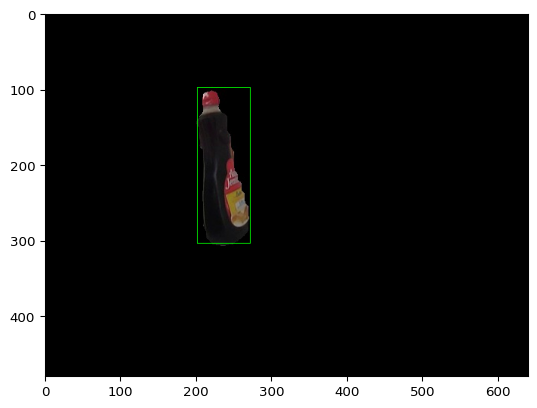

In [10]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline

item_path = os.path.join(img_dir, sudo_item_list[0])
img_file_name = random.choice(os.listdir(item_path))
img_path = os.path.join(item_path, img_file_name)
image = imageio.imread(img_path)

temp_path = os.path.join(sudo_item_list[0], img_file_name)

txt_path = os.path.join(txt_dir, temp_path[0:-3] + 'txt')
f = open(txt_path, 'r')
line = f.readline()
line.strip()
f.close()
b = line.split()
x = float(b[1])
y = float(b[2])
w = float(b[3])
h = float(b[4])
a1 = 640 * (x - w/2)
a2 = 640 * (x + w/2)
b1 = 480 * (y - h/2)
b2 = 480 * (y + h/2)

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=a1, x2=a2, y1=b1, y2=b2)
], shape=image.shape)

ia.imshow(bbs.draw_on_image(image))

In [ ]:
'''
#iternum = 6000 # 만들파일의 개수, 실제로 한다면 최소 10만장정도??

item_list = os.listdir(img_dir)

print('start iteration')
count=0

''' 

'''
# 1개에 배경 합성하는 코드
modified_dir = base_dir + '/1.competition_trainset/modified1'

for item in item_list:
    sample_item_path=os.path.join(img_dir,item)
    sample_img_list=os.listdir(sample_item_path)
    for sample in sample_img_list:
            sample_path=os.path.join(sample_item_path,sample)
            base_img=cv2.imread(sample_path)
            
            background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
            background_img = cv2.imread(background_img_path)
            base_img = addimage(background_img, base_img)
            
            file_name = f'/{count}+background'
            cv2.imwrite(modified_dir + file_name + '.jpg', base_img)
            
            txt_path = os.path.join(txt_dir,item, sample[0:-3] + 'txt')
            f = open(txt_path, 'r')
            line = f.readline()
            f.close()
            
            fw = open(modified_dir + file_name + '.txt', 'w')
            fw.write(line)
            fw.close()
            
            count+=1
            if count % 1000 == 0:
                print(f'iteration {count}times complete')
                
print('All iteration complete')
'''

'''
# 2개 이상의 이미지 합성하는 과정

for item in item_list:                         # item은 60개의 폴더이름 중 하나
    sample_item_path=os.path.join(img_dir,item)
    sample_img_list=os.listdir(sample_item_path)
    ex_item_list = [x for x in item_list if x!=item]
    for sample in sample_img_list:             # sample은 폴더 안의 100장의 이미지 이름 중 하나
            img_path_list = []                  # img_path_list 는 item/sample 형식
            square_list = []                    # square_list 는 bounding box 넓이 저장
            lines = [] # txt파일 정보 저장
            
            sample_path=os.path.join(item, sample)
            
            img_path_list.append(sample_path)
            
            n = 3                                 # 합성할 사진 개수 (기본 1개 + n개) 총 1+n개 물체
            modified_dir = base_dir + '/1.competition_trainset/modified4' # 합성된 사진은 modified폴더에 저장
            composeitem = random.sample(ex_item_list, n) # 합성할 아이템 뽑기 
            
            for compose_item in composeitem:
                    compose_item_path = os.path.join(img_dir, compose_item)
                    compose_img_list = os.listdir(compose_item_path)
                    compose_img_name = random.choice(compose_img_list)
                    img_path_list.append(os.path.join(compose_item, compose_img_name))
            #print(img_path_list)

            for img_path in img_path_list:
                txt_path = os.path.join(txt_dir, img_path[0:-3] + 'txt')
                f = open(txt_path, 'r')
                line = f.readline()
                line = line.strip() # 줄 끝의 줄 바꿈 문자 제거
                lines.append(line)  # 각 물체의 txt파일의 바운딩 박스 정보를 lines리스트에 저장
                b = line.split()  
                area = float(b[3])*float(b[4])*100
                square_list.append(area)
                f.close()
            
            dictionary = dict(zip(img_path_list, square_list))
            sorted_dictionary = dict(sorted(dictionary.items(), key=lambda x:x[1], reverse=True)) # 딕셔너리 정렬
            sorted_img_list = list(sorted_dictionary)
            
            base_img = cv2.imread(os.path.join(img_dir, sorted_img_list[0]))
            for i in range(1,n+1):
                compose_img = cv2.imread(os.path.join(img_dir, sorted_img_list[i]))
                base_img = addimage(base_img, compose_img)
                
            background_img_path = os.path.join(backgrounds_dir, random.choice(os.listdir(backgrounds_dir)))
            background_img = cv2.imread(background_img_path)
            base_img = addimage(background_img, base_img)
            
            file_name = f'/{n+1}_{count}+background'
            cv2.imwrite(modified_dir + file_name + '.jpg', base_img)

            #저장된 txt파일 정보 modified폴더에 저장하기
            fw = open(modified_dir + file_name + '.txt', 'w')
            fw.write(lines[0])
            for j in range(1,n+1):
                fw.write('\n'+lines[j])
            fw.close()
            
            count+=1
            if count % 1000 == 0:
                print(f'iteration {count}times complete')
                
print('All iteration complete')
'''